# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

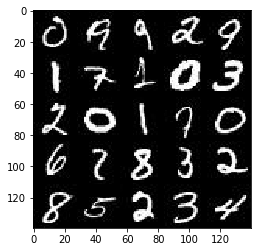

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

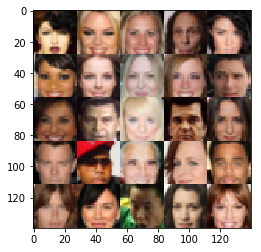

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32)

    return image_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(0.2 * x1, x1)
        relu1 = tf.nn.dropout(relu1, keep_prob=0.8)
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        relu2 = tf.nn.dropout(relu2, keep_prob=0.8)
        
        x3 = tf.layers.conv2d(relu2, 256, 4, strides=1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2 * bn3, bn3)
        relu3 = tf.nn.dropout(relu3, keep_prob=0.8)
                           
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)


    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)    
        x1 = tf.nn.dropout(x1, 0.8)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()

    steps = 0
    if(data_image_mode == "RGB"):
        out_channel_dim = 3
    elif(data_image_mode == "L"):
        out_channel_dim = 1
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],out_channel_dim,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        if(data_image_mode == "RGB"):
            out_channel_dim = 3
        elif(data_image_mode == "L"):
            out_channel_dim = 1
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images*2, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images*2, lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images*2})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.5846... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.6922... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.6672... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 1.2962
Epoch 1/2... Discriminator Loss: 1.0089... Generator Loss: 1.7165
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 0.8850... Generator Loss: 1.7140
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.6844
Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 1.0230


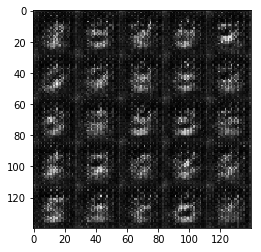

Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 1.0712
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 1.1565
Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 1.4643
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.2811
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.2539
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 1.1824
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 1.3204
Epoch 1/2... Discriminator Loss: 1.3861... Generator Loss: 1.1095
Epoch 1/2... Discriminator Loss: 1.3285... Generator Loss: 1.2393


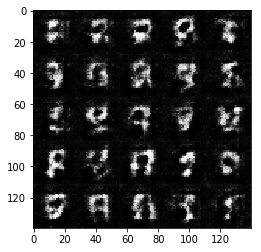

Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 1.1303
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 1.5494... Generator Loss: 0.7759
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 1.1682
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 1.0442
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 1.6771
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.1955... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 1.1916


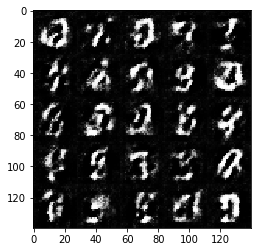

Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 1.5506
Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 1.2779
Epoch 1/2... Discriminator Loss: 0.9730... Generator Loss: 1.3977
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 1.1505... Generator Loss: 1.3624
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 1.7797
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 1.4150
Epoch 1/2... Discriminator Loss: 1.1232... Generator Loss: 1.0273


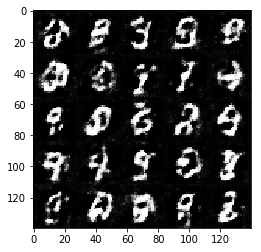

Epoch 1/2... Discriminator Loss: 1.1206... Generator Loss: 1.0186
Epoch 1/2... Discriminator Loss: 1.0515... Generator Loss: 1.4139
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.3161
Epoch 1/2... Discriminator Loss: 1.2297... Generator Loss: 0.7227
Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 1.4635
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 1.5144
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.7458
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.8942


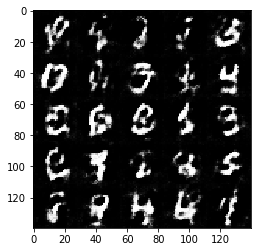

Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.7787
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.3326
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 2.0123
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.6375
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 2.5522
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 1.6275
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 2.0251
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 1.1991


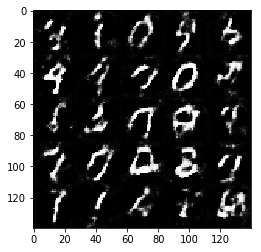

Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.4259
Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 1.4181
Epoch 1/2... Discriminator Loss: 1.1902... Generator Loss: 0.9605
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.0380
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 1.7106
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.2910
Epoch 1/2... Discriminator Loss: 1.1624... Generator Loss: 1.2004
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.0171... Generator Loss: 0.9821


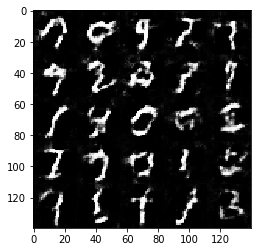

Epoch 1/2... Discriminator Loss: 1.0240... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 1.3988
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.8830
Epoch 1/2... Discriminator Loss: 1.0571... Generator Loss: 1.3218
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.7468
Epoch 1/2... Discriminator Loss: 1.1947... Generator Loss: 1.4896
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.8793
Epoch 1/2... Discriminator Loss: 1.0291... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 2.1909
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.0685


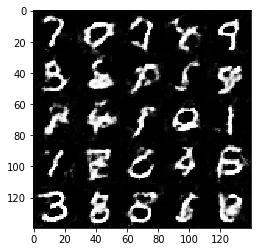

Epoch 1/2... Discriminator Loss: 1.0636... Generator Loss: 1.5158
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 1.4765
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 1.8677
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 1.1853
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 1.1677
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.3286
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 1.6962
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.7896


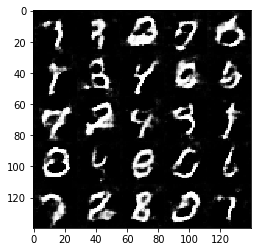

Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.1333
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 1.7148
Epoch 1/2... Discriminator Loss: 1.0322... Generator Loss: 1.4245
Epoch 2/2... Discriminator Loss: 1.3429... Generator Loss: 2.1315
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.8718
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 1.2567
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 1.3641
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 2.3007
Epoch 2/2... Discriminator Loss: 1.2506... Generator Loss: 0.9178
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 1.2461


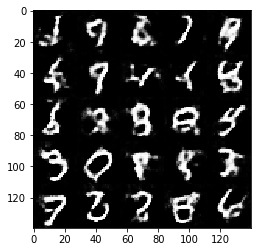

Epoch 2/2... Discriminator Loss: 1.1294... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.1874
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 1.1578
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 2.2388
Epoch 2/2... Discriminator Loss: 1.0757... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.9889
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.6728
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 1.0095... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 1.1341... Generator Loss: 1.6181


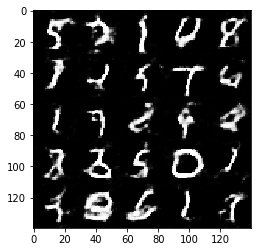

Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.7958
Epoch 2/2... Discriminator Loss: 1.1766... Generator Loss: 1.5925
Epoch 2/2... Discriminator Loss: 1.0430... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.4974... Generator Loss: 0.5583
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.0712
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 1.6940
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.8380
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.0057
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.1031


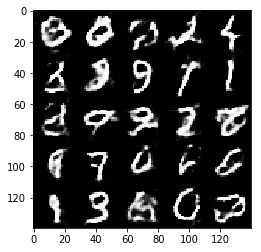

Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 0.9665
Epoch 2/2... Discriminator Loss: 1.2643... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.9306
Epoch 2/2... Discriminator Loss: 1.0051... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 1.0481... Generator Loss: 1.3867
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 1.3016
Epoch 2/2... Discriminator Loss: 0.9136... Generator Loss: 1.2616
Epoch 2/2... Discriminator Loss: 1.0805... Generator Loss: 1.0883
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 1.1153... Generator Loss: 0.8518


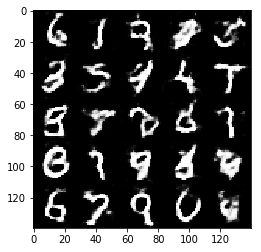

Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.0574
Epoch 2/2... Discriminator Loss: 1.1497... Generator Loss: 0.9917
Epoch 2/2... Discriminator Loss: 1.0544... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 1.0543... Generator Loss: 1.2438
Epoch 2/2... Discriminator Loss: 1.2778... Generator Loss: 2.1253
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 1.2060
Epoch 2/2... Discriminator Loss: 1.0144... Generator Loss: 1.3294
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.4423
Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 1.1374


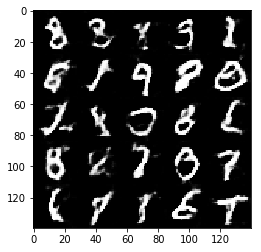

Epoch 2/2... Discriminator Loss: 1.1434... Generator Loss: 1.3572
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.4385
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 1.4306
Epoch 2/2... Discriminator Loss: 1.1887... Generator Loss: 0.9251
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 1.5409
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 1.1831
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.0641
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.8722
Epoch 2/2... Discriminator Loss: 0.9332... Generator Loss: 1.2616


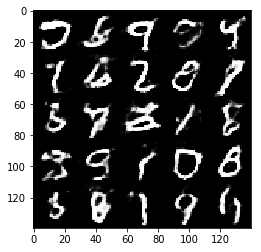

Epoch 2/2... Discriminator Loss: 1.1226... Generator Loss: 0.8046
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 1.4012
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.9262
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 1.2340
Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 1.2350
Epoch 2/2... Discriminator Loss: 0.9644... Generator Loss: 1.4315
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.6998


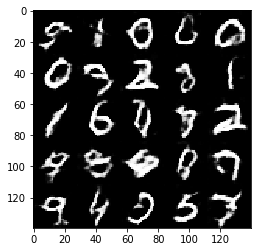

Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 0.9224... Generator Loss: 1.4101
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.5017
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 1.2021
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 1.6872
Epoch 2/2... Discriminator Loss: 0.9249... Generator Loss: 1.3885
Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 1.6408
Epoch 2/2... Discriminator Loss: 0.8934... Generator Loss: 1.6264


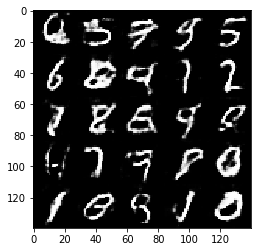

Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.5456
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 1.0185
Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 1.3659
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 1.4569
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.2468
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 1.5441
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.4514
Epoch 2/2... Discriminator Loss: 0.7934... Generator Loss: 1.3571
Epoch 2/2... Discriminator Loss: 0.9972... Generator Loss: 1.2882
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 1.0224


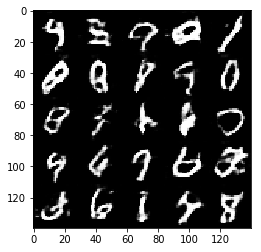

Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 1.2998
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.2859
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.4361
Epoch 2/2... Discriminator Loss: 0.9470... Generator Loss: 1.4261
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 2.4190
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 1.3809


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 0.8249... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.2898
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.9894
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 2.3868
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.4491
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.7687


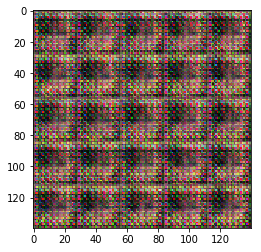

Epoch 1/1... Discriminator Loss: 0.7385... Generator Loss: 2.0990
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.9133
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 2.5352
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 3.1249
Epoch 1/1... Discriminator Loss: 0.8033... Generator Loss: 4.2635
Epoch 1/1... Discriminator Loss: 0.6322... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.5590
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.9119
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.7485
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.8458


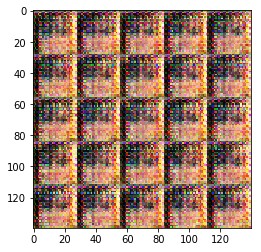

Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 3.0957
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 3.2876
Epoch 1/1... Discriminator Loss: 0.5919... Generator Loss: 2.8686
Epoch 1/1... Discriminator Loss: 0.4873... Generator Loss: 2.3514
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.5658
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 2.3215
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 3.3430
Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 3.5510
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 5.3623
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.3337


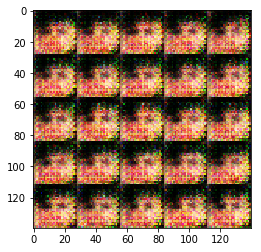

Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 2.7714
Epoch 1/1... Discriminator Loss: 0.4949... Generator Loss: 2.9661
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 2.6552
Epoch 1/1... Discriminator Loss: 0.4699... Generator Loss: 3.4103
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.8040
Epoch 1/1... Discriminator Loss: 0.4874... Generator Loss: 3.3754
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 2.7382
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 3.0723
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 3.2857
Epoch 1/1... Discriminator Loss: 0.4757... Generator Loss: 2.9640


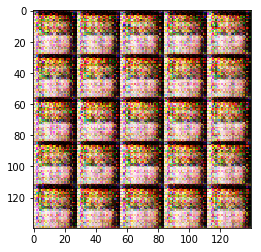

Epoch 1/1... Discriminator Loss: 0.4847... Generator Loss: 3.7264
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.9601
Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 2.8976
Epoch 1/1... Discriminator Loss: 0.4620... Generator Loss: 3.1125
Epoch 1/1... Discriminator Loss: 0.4730... Generator Loss: 2.8516
Epoch 1/1... Discriminator Loss: 0.4306... Generator Loss: 2.9606
Epoch 1/1... Discriminator Loss: 0.4688... Generator Loss: 3.3752
Epoch 1/1... Discriminator Loss: 0.4138... Generator Loss: 3.8169
Epoch 1/1... Discriminator Loss: 0.4020... Generator Loss: 3.7874
Epoch 1/1... Discriminator Loss: 0.4333... Generator Loss: 4.3052


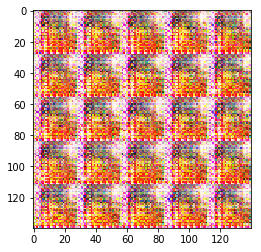

Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 4.2162
Epoch 1/1... Discriminator Loss: 0.3708... Generator Loss: 4.1292
Epoch 1/1... Discriminator Loss: 0.3776... Generator Loss: 3.8474
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 4.4496
Epoch 1/1... Discriminator Loss: 0.4044... Generator Loss: 3.3255
Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 3.7263
Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 2.5120
Epoch 1/1... Discriminator Loss: 0.5052... Generator Loss: 2.4548
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.7637
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.5515


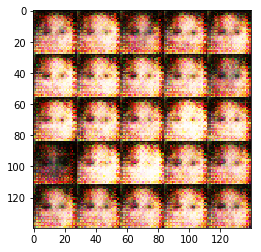

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 2.7232
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.8974
Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 2.9563
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 2.6542
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 2.2477
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.4548
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.9768
Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 2.4761
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.9779


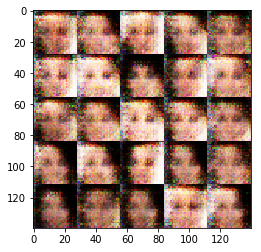

Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 3.3605
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.1318
Epoch 1/1... Discriminator Loss: 0.7394... Generator Loss: 3.4660
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 3.1414
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.6884
Epoch 1/1... Discriminator Loss: 0.7417... Generator Loss: 1.7755
Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.8570


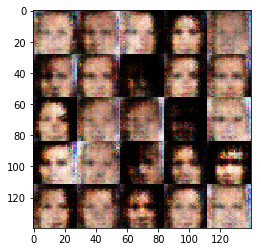

Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.7607
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.5695
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.3633
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.5005
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 2.0592
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 2.1894
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.9149
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 2.0633


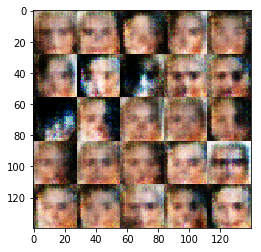

Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 2.2635
Epoch 1/1... Discriminator Loss: 0.8926... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 0.7562... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 2.0166
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.1230
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.9499
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.7377


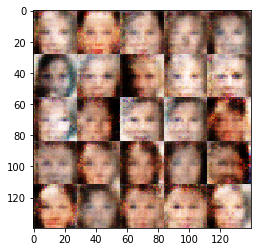

Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 2.4214
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 0.8969... Generator Loss: 1.4876
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.6497
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.8857
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 2.0338
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.5794


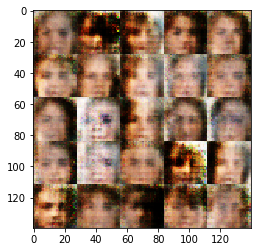

Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.7502
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.8740... Generator Loss: 1.4232
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.5848
Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 2.0295
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 1.0651
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.2407


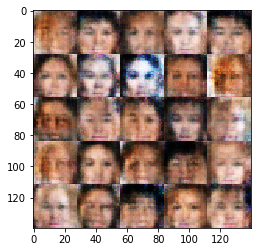

Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 2.2118
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 1.3766
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.3896
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.9952
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 2.2096
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.1097
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.1243


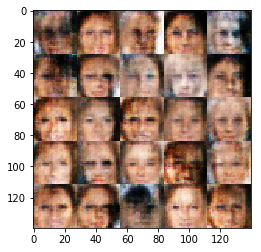

Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 1.3888
Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 1.7868
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.5078
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.0943... Generator Loss: 1.7218
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 1.1667
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.0092... Generator Loss: 0.9741


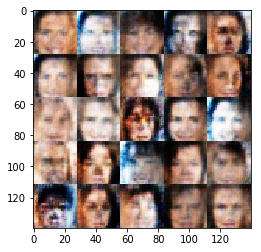

Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0687


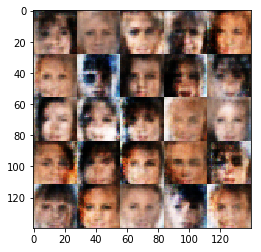

Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.0037
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.1009
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 1.4224
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.1491
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.9144


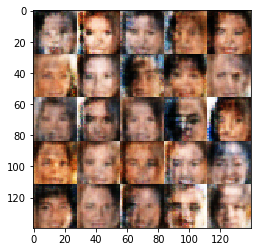

Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.0307
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.1174


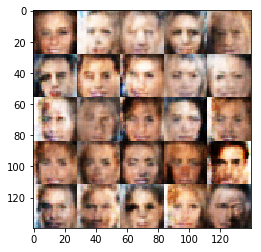

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.9426


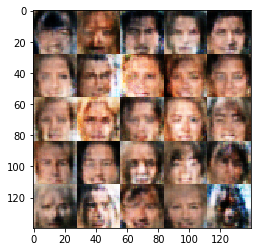

Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.0582
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.0328
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 1.1700
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0682
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8500


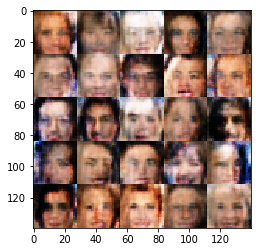

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.1152
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.2229
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 1.3235
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.9254


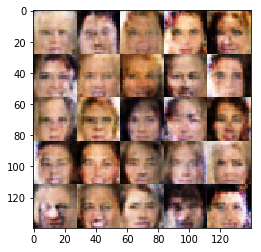

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.1789
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.3471
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.0233
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 1.0368


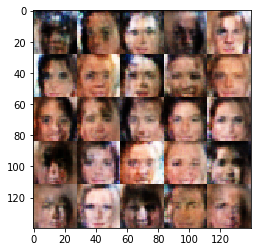

Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 1.0788
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 1.0035


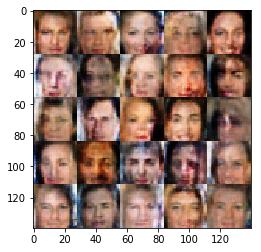

Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.1607
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.3964
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 1.0617
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.0478


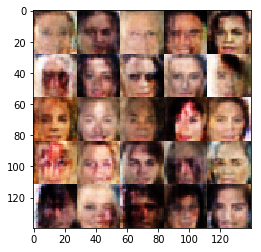

Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.4532
Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.1660


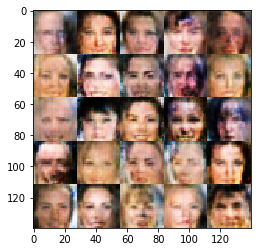

Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.3157
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 1.2750
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.3476
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 1.1535


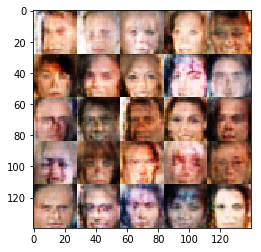

Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 1.1706... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.3905
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.2484
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.1319


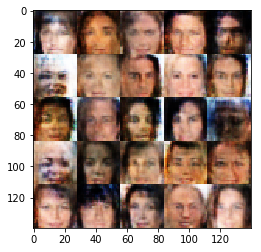

Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 0.9608
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.9054


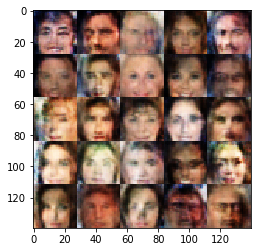

Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 1.1221
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.2699... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 1.0207... Generator Loss: 1.3150


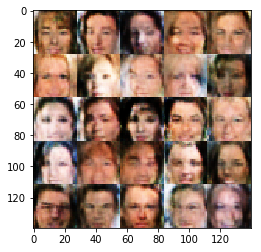

Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.4141
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0498
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 0.9704


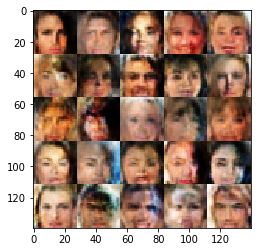

Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.4312
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 1.1205
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8941


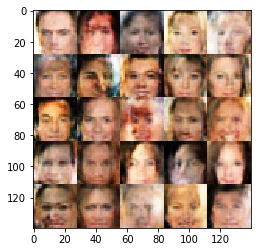

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.9201
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.9301
Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 1.0134


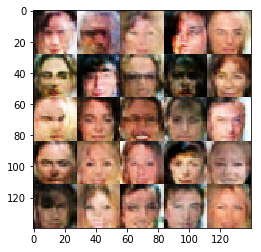

Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 1.0839
Epoch 1/1... Discriminator Loss: 1.2944... Generator Loss: 1.0325
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 1.1402
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.9666
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.9312
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.1953


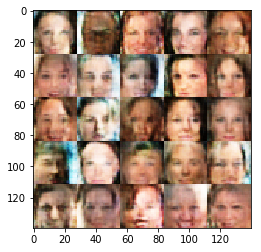

Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.2884
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.0275
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 1.0744
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.9802


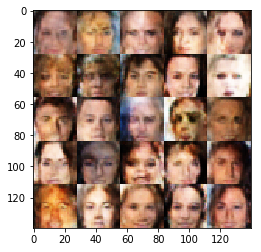

Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 1.3084
Epoch 1/1... Discriminator Loss: 1.0606... Generator Loss: 1.3425
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.9852
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 1.0645
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.9950


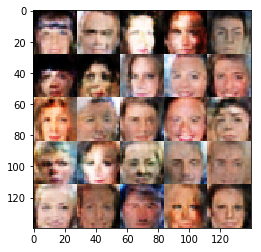

Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.2455
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.6104
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.0624
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 1.1419


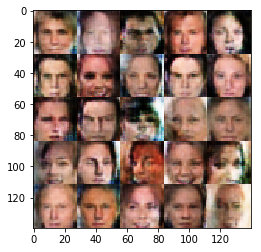

Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.7506


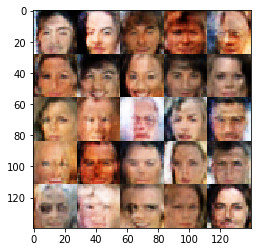

Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.9935
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.3289
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.6573


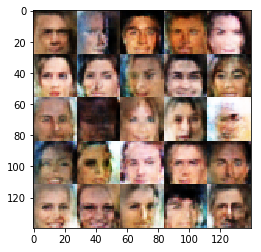

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8836
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.1029
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.9798
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.8500


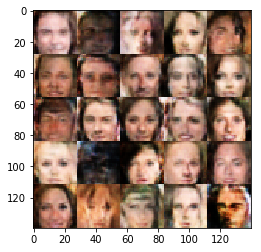

Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 1.0373
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9351
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.1307
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7819


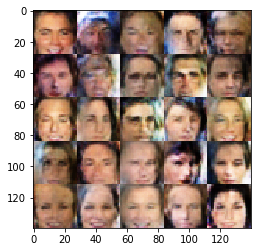

Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.8650


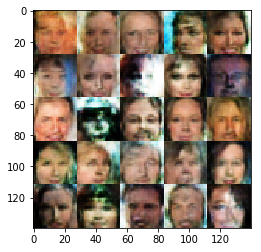

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 0.9523
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 1.4015
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.8869


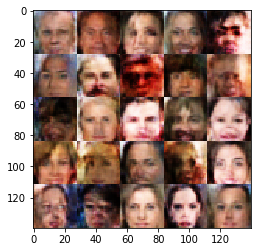

Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 1.2767
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.3469


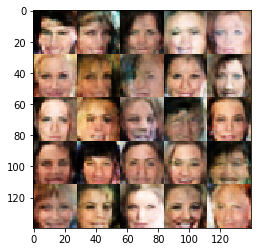

Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.0918
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.0952
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.2452
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.1960


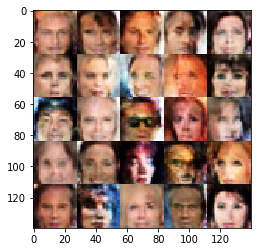

Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 1.1813
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 1.6481
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 1.1073


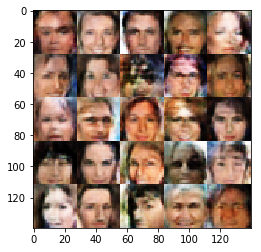

Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9866


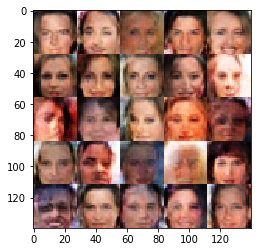

Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.2572
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.2827
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 1.2352
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6847


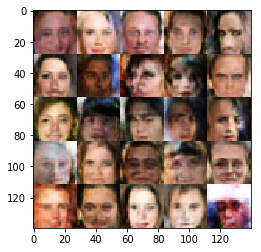

Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 1.0687
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 1.1512
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.1339


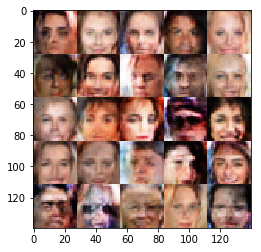

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 1.4997
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 1.0757
Epoch 1/1... Discriminator Loss: 1.2881... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.8552


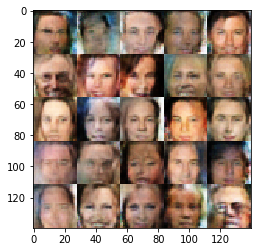

Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 1.0220
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.3266
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.9316
Epoch 1/1... Discriminator Loss: 1.2265... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.5934


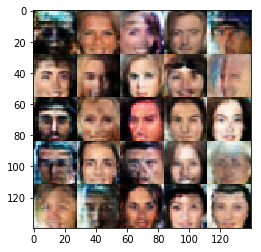

Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 1.1008
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.1500... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.1164... Generator Loss: 1.0421


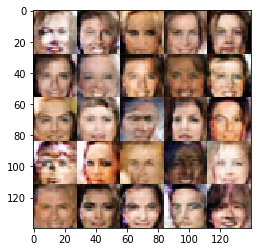

Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 1.0714
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8329


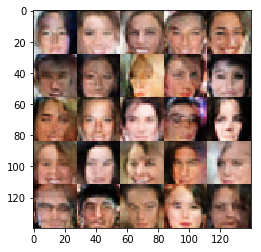

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 1.7030
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 0.8475... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.0817
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.2133
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.2386


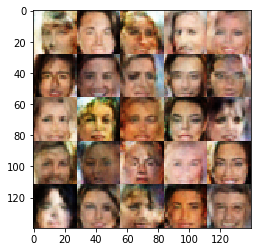

Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.9468
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6924


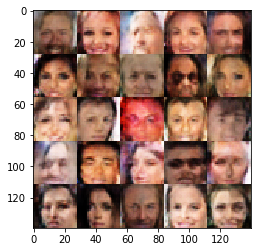

Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9152
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.9249


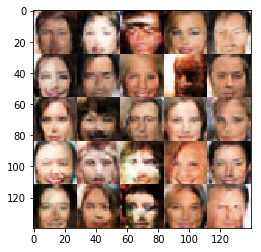

Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 1.0659
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.9722
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 1.0961
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.0566


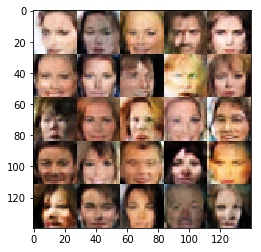

Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 1.0642
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.3173
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.3180
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.2150
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.2020
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7679


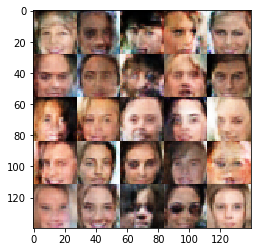

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.3051
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 1.5765
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 1.0493
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 1.2217
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.3294
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 1.0927... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 1.3883


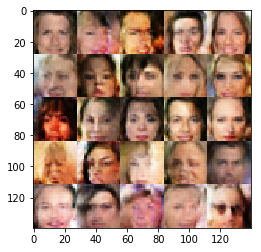

Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.7973
Epoch 1/1... Discriminator Loss: 1.1688... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 1.0264


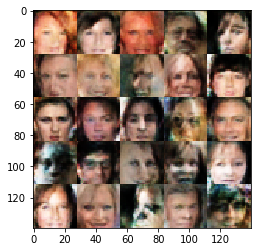

Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.1528
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.9110
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.8545


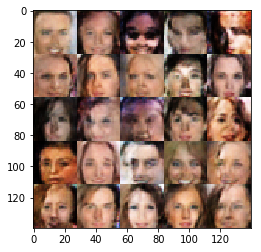

Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.0518


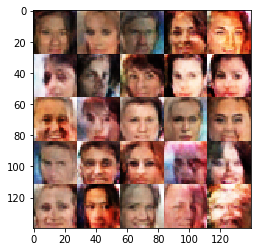

Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.5007
Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 1.5570
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9466


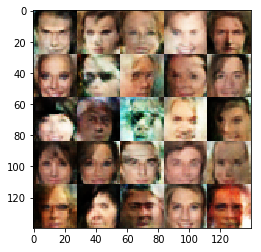

Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9960
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 1.1869
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 1.0035
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.8197


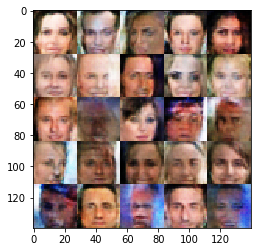

Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 1.4009
Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.1323... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9234


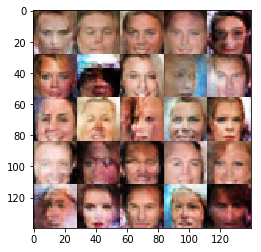

Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 1.3815


In [19]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。